# Stock Prediction - LSTM 

## Import Libraries

In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
from datetime import datetime
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.preprocessing import MinMaxScaler
from pandas_profiling import ProfileReport
# from keras.models import Sequential
# from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

C:\Users\wgutierrezp\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Ingest Data 

In [13]:
#Get the stock quote 
df = web.DataReader('TSLA', data_source='yahoo', start='2000-01-01', end=datetime.date(datetime.now())) 
#Show the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2580 entries, 2010-06-29 to 2020-09-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2580 non-null   float64
 1   Low        2580 non-null   float64
 2   Open       2580 non-null   float64
 3   Close      2580 non-null   float64
 4   Volume     2580 non-null   float64
 5   Adj Close  2580 non-null   float64
dtypes: float64(6)
memory usage: 141.1 KB


## Exploratory Data Analysis

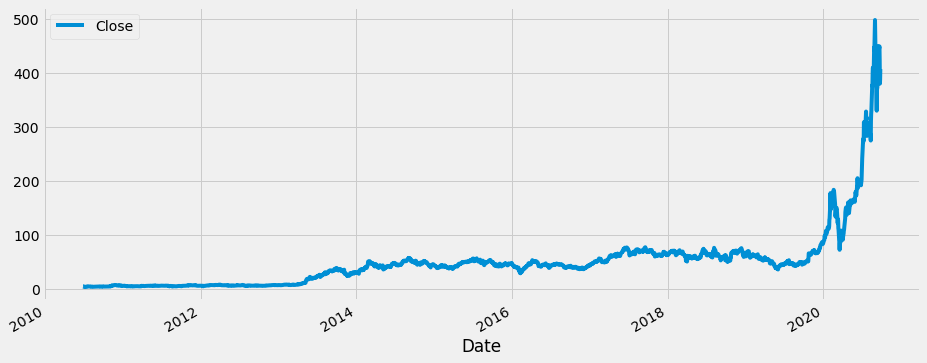

In [14]:
df.plot(y='Close', kind='line', figsize=(14,6))

In [16]:
report = df.profile_report()
report.to_file('TSLA_eda_report.html')

## Data Preprocessing & Wrangling

In [17]:
#Select closing data
df_close = df[['Close']]

In [18]:
#Scale the data
scaler = sklearn.preprocessing.MinMaxScaler()
X = scaler.fit_transform(df_close)
X.shape

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
training_data_len = math.ceil( len(df_close) *.8)
train_data = X[0:training_data_len  , : ]
X_train,X_test = train_test_split(X, test_size=0.2 ,shuffle=False)

x_train=[]
y_train = []
for i in range(60,len(X_train)):
    x_train.append(X_train[i-60:i,0])
    y_train.append(X_train[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

## Model Training

In [19]:
#Build the LSTM network model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(keras.layers.LSTM(units=50, return_sequences=False))
model.add(keras.layers.Dense(units=25))
model.add(keras.layers.Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
2004/2004 [==============================] - 24s 12ms/step - loss: 8.0820e-05
Epoch 2/5
2004/2004 [==============================] - 24s 12ms/step - loss: 3.6994e-05
Epoch 3/5
2004/2004 [==============================] - 24s 12ms/step - loss: 2.6077e-05
Epoch 4/5
2004/2004 [==============================] - 24s 12ms/step - loss: 2.1507e-05
Epoch 5/5
2004/2004 [==============================] - 24s 12ms/step - loss: 1.8678e-05


In [20]:
model.save('models/TSLA_LSTM_60D')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/TSLA_LSTM_60D\assets


## Model Evaluation

In [21]:
#Test data set
test_data = X[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test = scaler.inverse_transform(X[training_data_len:, :]) #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
print(x_test.shape)
print(y_test.shape)

(516, 60)
(516, 1)


In [22]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [24]:
from sklearn.metrics import accuracy_score, mean_squared_error
rmse = mean_squared_error(predictions, y_test,squared=False)
rmse

16.9601334843201

<ipython-input-26-d66e7487486a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


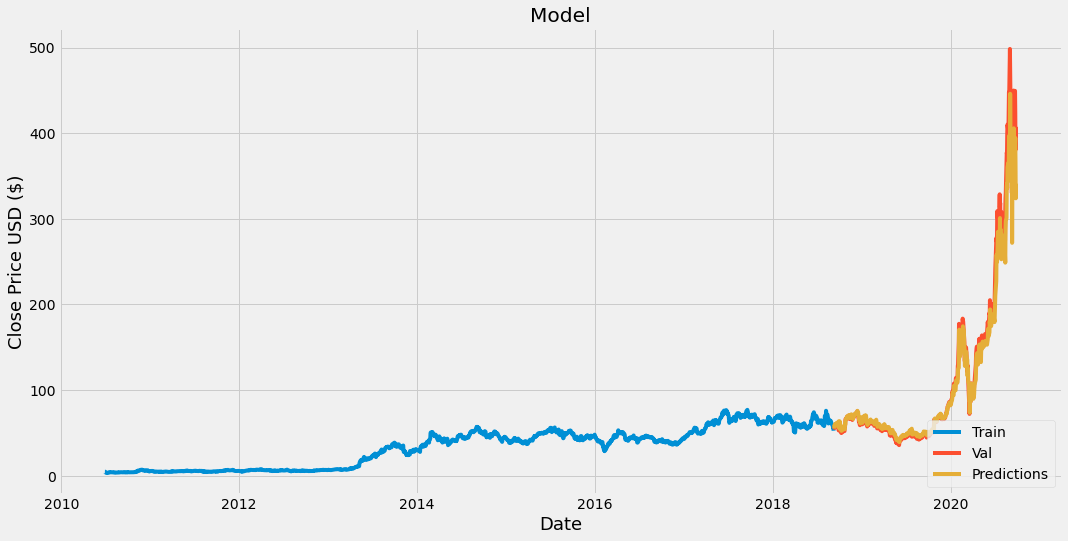

In [26]:
#Plot/Create the data for the graph
train = df_close[:training_data_len]
valid = df_close[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Generate Output Dataframe

In [27]:
%load_ext autoreload

%autoreload 2
from utils.preprocessing import compute_stock_features

x, y = compute_stock_features(X)

In [28]:
p_list = [np.zeros(x.shape[1]),model.predict(x)]
df_close['Predictions'] = np.array([i for l in p_list for i in l])

<ipython-input-28-d16129c5e9e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['Predictions'] = np.array([i for l in p_list for i in l])
